In [1]:
from ftplib import FTP
from io import BytesIO
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt



In [146]:

def download_spectrum_ftp(ftp_url):
    ftp_host = "ftp.eso.org"
    ftp_path = ftp_url.replace("ftp://ftp.eso.org/", "")
    
    with FTP(ftp_host) as ftp:
        ftp.login()
        with BytesIO() as bio:
            ftp.retrbinary(f"RETR {ftp_path}", bio.write)
            bio.seek(0)
            return bio.getvalue() 

# solo spectros en main sequence (que terminen en v)
spectra_urls = {
    "O": [
        "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/uko5v.fits",
        "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/uko9v.fits"

    ],
    "B": [
        "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/ukb0v.fits",
        "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/ukb1v.fits"
    ],
    "A": [
        "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/uka0v.fits",
        "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/uka2v.fits"
    ],
    "F": [
        "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/ukf0v.fits",
        "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/ukf2v.fits"
    ],
    "G": [
        "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/ukg0v.fits",
        "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/ukg2v.fits"
    ],
    "K": [
        "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/ukk0v.fits",
        "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/ukk2v.fits"
    ],
    "M": [
        "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/ukm0v.fits",
        "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/ukm1v.fits"
    ]
}

spectra = {}
for key, urls in spectra_urls.items():
    spectra[key] = [download_spectrum_ftp(url) for url in urls]


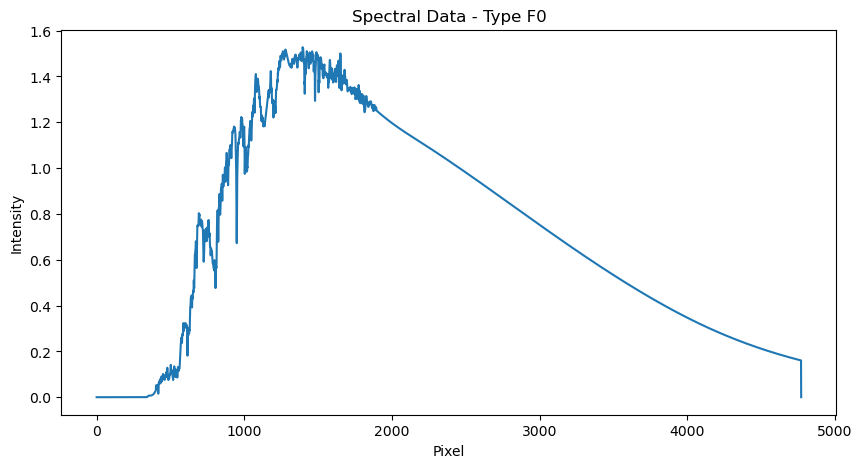

In [148]:

# Esto esta acá porque sino se me cerraban los fits

def open_fits_from_data(data):
    with fits.open(BytesIO(data)) as hdul:
        header = hdul[0].header
        data = hdul[0].data
        return header, data

# Ejemplo con espectro O
fits_data_O = spectra['M'][0]

# Obtener la cabecera y los datos del archivo FITS
header_O, data_O = open_fits_from_data(fits_data_O)


# print("Header keys:", header_O.keys())
# print("First few data points:", data_O[:10])

# Visualizar el espectro
plt.figure(figsize=(10,5))
plt.plot(data_O)
plt.xlabel('Pixel')
plt.ylabel('Intensity')
plt.title('Spectral Data - Type F0')
plt.show()


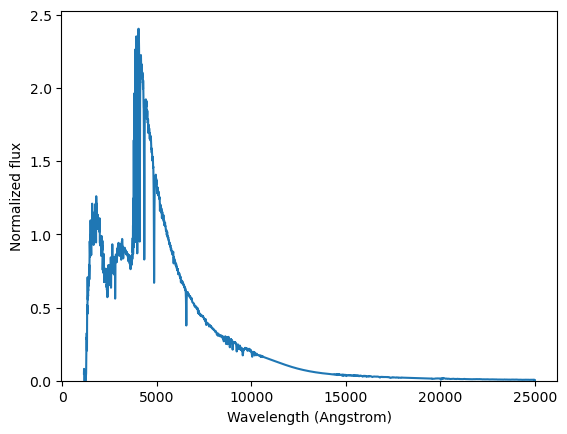

In [118]:

from astropy.wcs import WCS

# Esto esta acá porque sino se me cerraban los fits

def open_fits_from_data(data):
    with fits.open(BytesIO(data)) as hdul:
        header = hdul[0].header
        data = hdul[0].data
        return header, data

# Ejemplo con espectro O
fits_data_O = spectra['A'][1]

# Obtener la cabecera y los datos del archivo FITS
header_O, data_O = open_fits_from_data(fits_data_O)


flux = data_O
w = WCS(header_O, naxis=1, relax=False, fix=False)
lam = w.wcs_pix2world(np.arange(len(flux)), 0)[0]

plt.plot(lam, flux)
plt.ylim(0, )
plt.xlabel('Wavelength (Angstrom)')
plt.ylabel('Normalized flux')

plt.show()

In [116]:
 np.sum(data_O)

4967.001

In [30]:
#info del header
header_O

SIMPLE  =                    T / Fits standard                                  
BITPIX  =                  -32 / Bits per pixel                                 
NAXIS   =                    1 / Number of axes                                 
NAXIS1  =                 4771 / Axis length                                    
ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 1999' / FITS file originator        
EXTEND  =                    F / File may contain extensions                    
DATE    = '2000-02-16T18:17:18' / Date FITS file was generated                  
IRAF-TLM= '15:17:17 (16/02/2000)' / Time of last modification                   
APNUM1  = '1 1     '                                                            
WCSDIM  =                    1                                                  
CTYPE1  = 'LINEAR  '                                                            
CRVAL1  =                1150.                                                  
CRPIX1  =                   

In [144]:




# Función para normalizar un espectro estelar en relación a la luminosidad total

def normalize_spectrum_to_luminosity(header, data):

    # Integrar la luminosidad con respecto a long de onda, asi obtenemos la luminosidad total del espectro
    def calculate_total_luminosity(wavelength, spectrum):
        luminosity = np.trapz(spectrum, x=wavelength)
        return luminosity 
    
    # Infio del header
    crpix1 = header['CRPIX1']  # Punto de referencia del píxel
    crval1 = header['CRVAL1']  # Valor del píxel en crpix1
    cdelt1 = header['CDELT1']  # Incremento por píxel

    # Calcular el rango de longitud de onda
    wavelength = crval1 + (np.arange(len(data)) - crpix1 + 1) * cdelt1

    # integramos
    total_luminosity = calculate_total_luminosity(wavelength, data)

    # Normalizar el espectro dividiendo por la luminosidad total
    normalized_spectrum = data  / total_luminosity

    return wavelength, normalized_spectrum, total_luminosity

# Ejemplo
fits_data_O = spectra['F'][0]

# Obtener la cabecera y los datos del archivo FITS
header_O, data_O = open_fits_from_data(fits_data_O)

# Normalizar el espectro en relación a la luminosidad
wavelength_O, normalized_spectrum_O, total_luminosity_O = normalize_spectrum_to_luminosity(header_O, data_O)

# Visualizar el espectro normalizado (opcional)
plt.figure(figsize=(10,5))
plt.plot(wavelength_O, normalized_spectrum_O)
plt.xlabel('Wavelength')
plt.ylabel('Normalized Intensity')
plt.title('Normalized Spectral Data - Type F (Normalized to Luminosity)')
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

plt.show()

# Imprimir la luminosidad total del espectro (opcional)
print(f"Luminosity of Type O spectrum: {total_luminosity_O}")

KeyError: 'F'

In [121]:
np.sum(normalized_spectrum_O)

0.20024905

In [149]:
intrinsic_lum = {'O5': 846000, 'O9': 95000,
                 'B0':20000,'B1': 4600,
                 'A0': 22, 'A2': 18,
                 'F0': 4.3, 'F2': 3.3,
                 'G0': 1.3, 'G2': 1,
                 'K0': 0.54, 'K2': 0.38,
                 'M0': 0.069, 'M1': 0.064}

Here is the `intrinsic_lum` dictionary formatted as a table for easy copying to a slide:

| Spectral Type | Intrinsic Luminosity (L⊙) |
|---------------|----------------------------|
| O5            | 846,000                    |
| O9            | 95,000                     |
| B0            | 20,000                     |
| B1            | 4,600                      |
| A0            | 22                         |
| A2            | 18                         |
| F0            | 4.3                        |
| F2            | 3.3                        |
| G0            | 1.3                        |
| G2            | 1                          |
| K0            | 0.54                       |
| K2            | 0.38                       |
| M0            | 0.069                      |
| M1            | 0.064                      |

You can copy this table directly into your slide.

In [128]:

# Automatizado para todo
all_spectra_data = {}

for key, spectra_list in spectra.items():
    all_spectra_data[key] = []
    for fits_data in spectra_list:
        
        header, data = open_fits_from_data(fits_data)
        
        wavelength, normalized_spectrum, total_luminosity = normalize_spectrum_to_luminosity(header, data)
        
        all_spectra_data[key].append({
            'header': header,
            'data': data,
            'wavelength': wavelength,
            'normalized_spectrum': normalized_spectrum,
            'total_luminosity': total_luminosity
        })

for key, spectra_list in all_spectra_data.items():
    print(f"Type {key} spectra:")
    for idx, spectrum_data in enumerate(spectra_list):
        print(f"Spectrum {idx + 1}: Total Luminosity = {spectrum_data['total_luminosity']}")


Type O spectra:
Spectrum 1: Total Luminosity = 24804.11807811528
Spectrum 2: Total Luminosity = 64560.390511720325
Type B spectra:
Spectrum 1: Total Luminosity = 66340.11379241594
Spectrum 2: Total Luminosity = 46580.775226939004
Type A spectra:
Spectrum 1: Total Luminosity = 8276.418107565842
Spectrum 2: Total Luminosity = 7534.038258211222
Type F spectra:
Spectrum 1: Total Luminosity = 6690.0616004328
Spectrum 2: Total Luminosity = 6622.871028425079
Type G spectra:
Spectrum 1: Total Luminosity = 6975.68477616087
Spectrum 2: Total Luminosity = 7297.414025598791
Type K spectra:
Spectrum 1: Total Luminosity = 7726.988819530776
Spectrum 2: Total Luminosity = 8376.425316915847
Type M spectra:
Spectrum 1: Total Luminosity = 16961.40091382714
Spectrum 2: Total Luminosity = 19674.720405838012


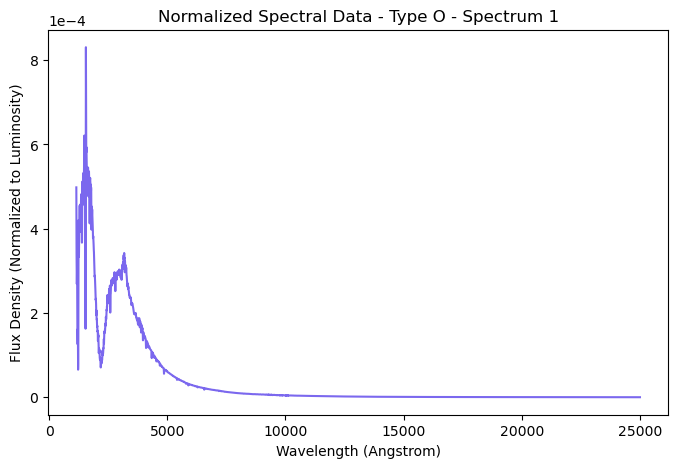

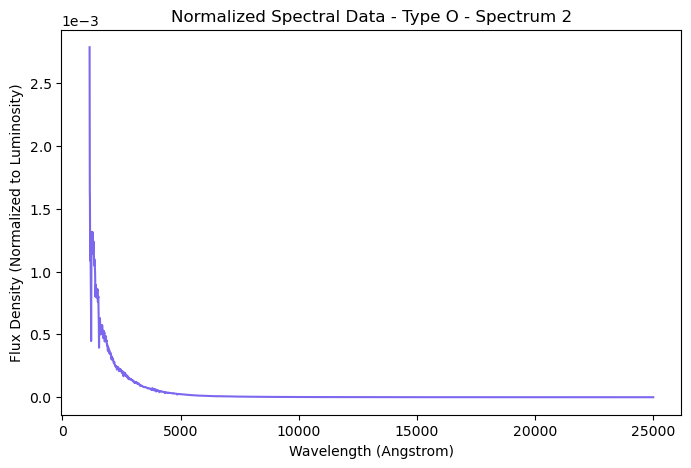

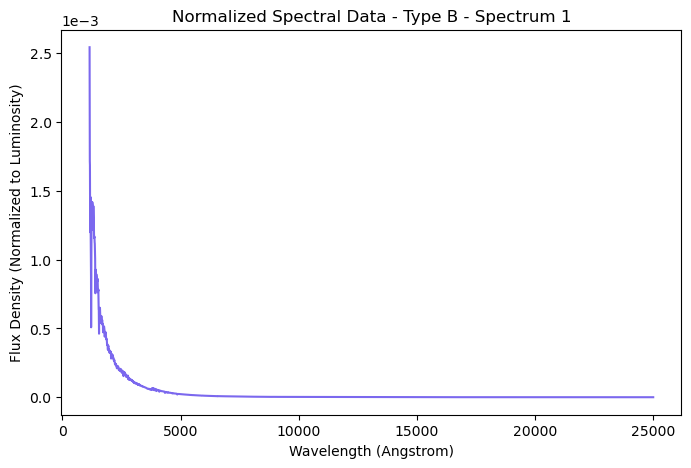

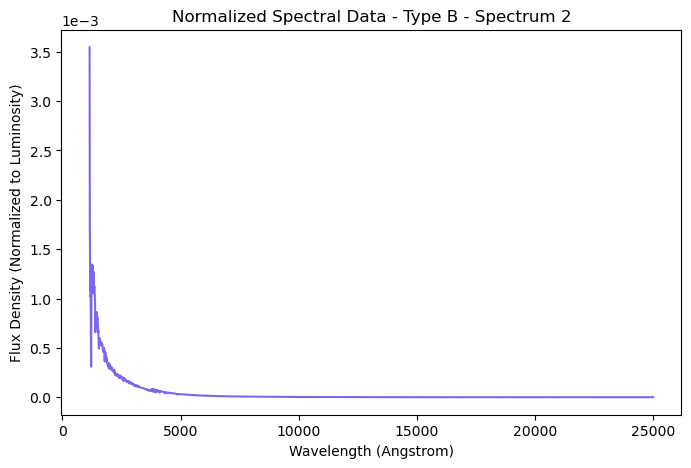

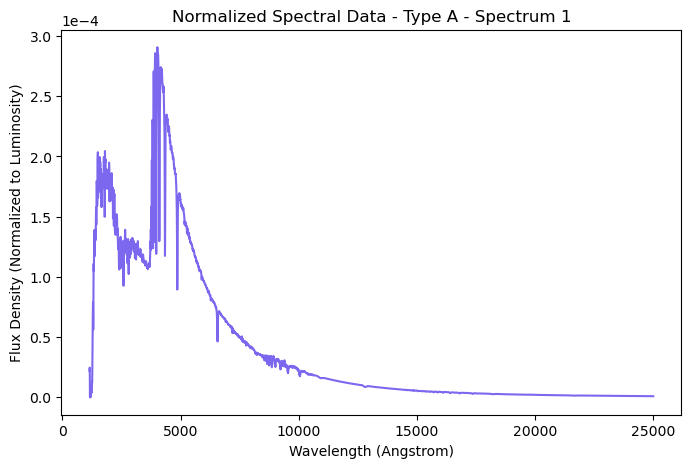

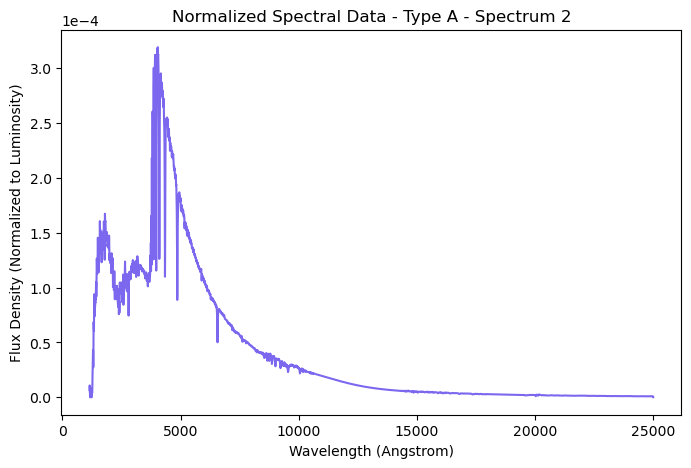

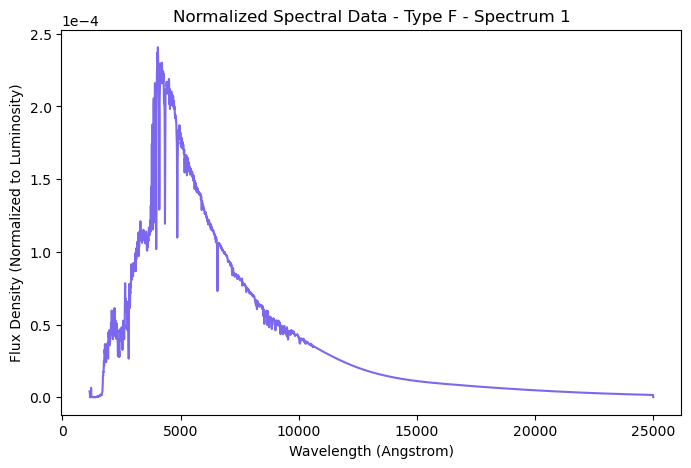

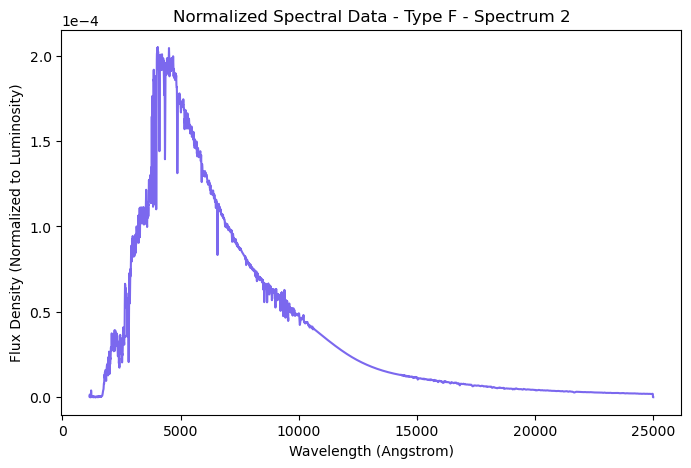

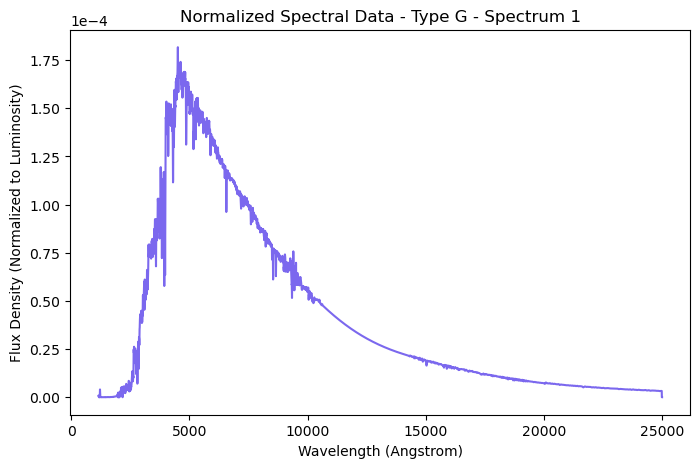

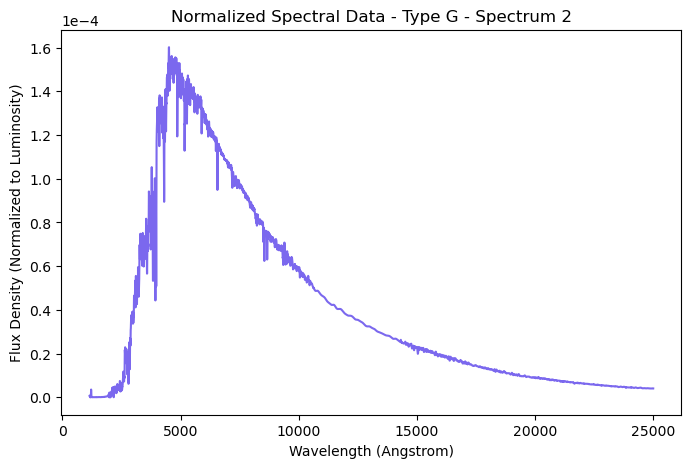

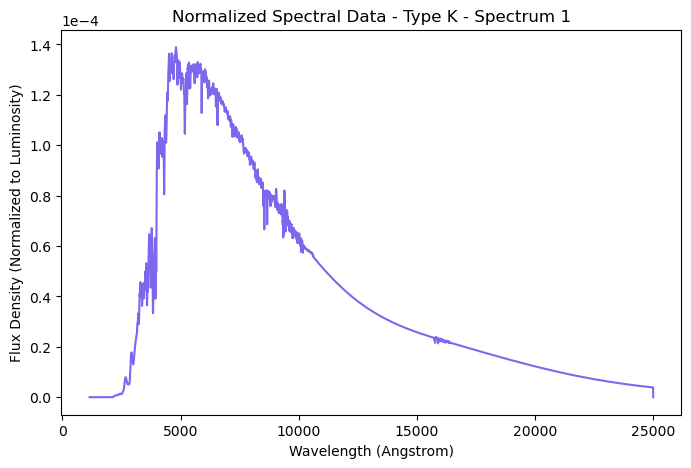

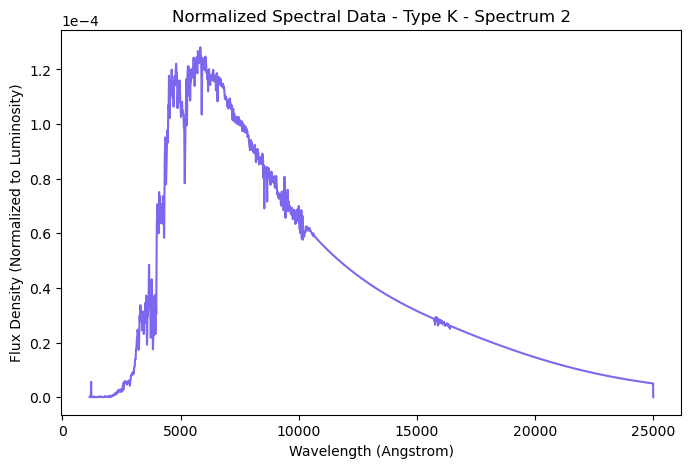

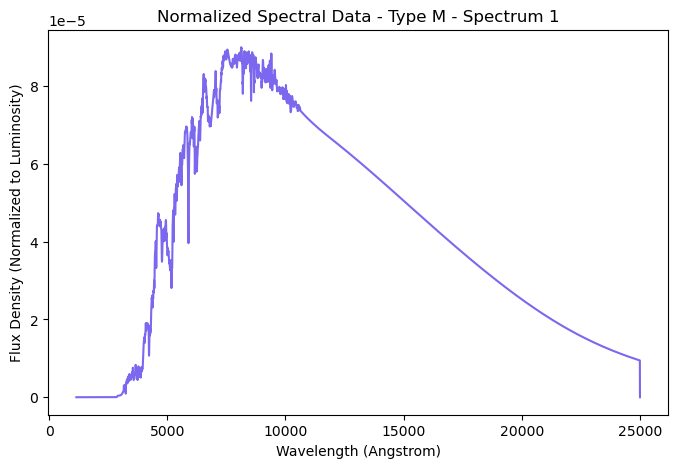

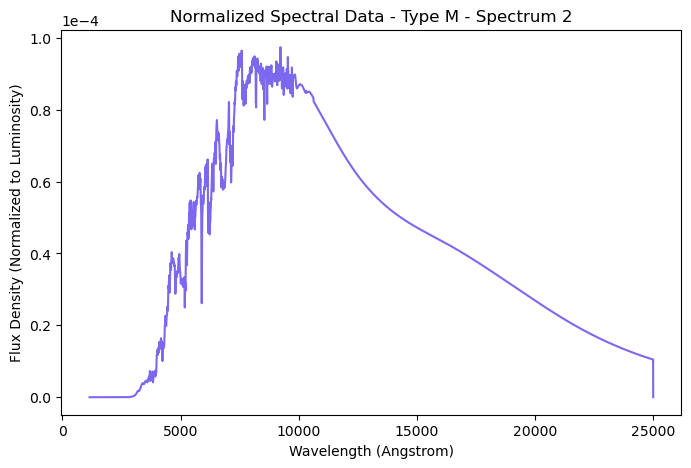

In [120]:
#Todos los graficos

for key, spectra_list in all_spectra_data.items():
    for idx, spectrum_data in enumerate(spectra_list):
        plt.figure(figsize=(8, 5))
        plt.plot(spectrum_data['wavelength'], spectrum_data['normalized_spectrum'], color='mediumslateblue')
        plt.xlabel('Wavelength (Angstrom)')
        plt.ylabel('Flux Density (Normalized to Luminosity)')
        plt.title(f'Normalized Spectral Data - Type {key} - Spectrum {idx + 1}')
        plt.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
        plt.show()


In [129]:
for key, spectra_list in spectra.items():
    for i, fits_data in enumerate(spectra_list):
        # Obtain the header and data from the FITS file
        header, data = open_fits_from_data(fits_data)

        # Normalize the spectrum relative to the luminosity
        wavelength, normalized_spectrum, total_luminosity = normalize_spectrum_to_luminosity(header, data)

        # Determine the spectral type and get the intrinsic luminosity
        spectral_type = f"{key}{i * 5}"  # Assuming each spectrum corresponds to O5, O9, B0, B1, etc.
        intrinsic_luminosity = intrinsic_lum[spectral_type]

        # Multiply the normalized spectrum by the intrinsic luminosity
        intrinsic_normalized_spectrum = normalized_spectrum * intrinsic_luminosity

        # Plot the spectrum
        plt.figure(figsize=(10, 5))
        plt.plot(wavelength, intrinsic_normalized_spectrum)
        plt.xlabel('Wavelength (Angstrom)')
        plt.ylabel('Flux Density or Specific Intensity')
        plt.title(f'Normalized Spectral Data - Type {spectral_type} (Intrinsic Luminosity Multiplied)')
        plt.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
        plt.show()

KeyError: 'O0'

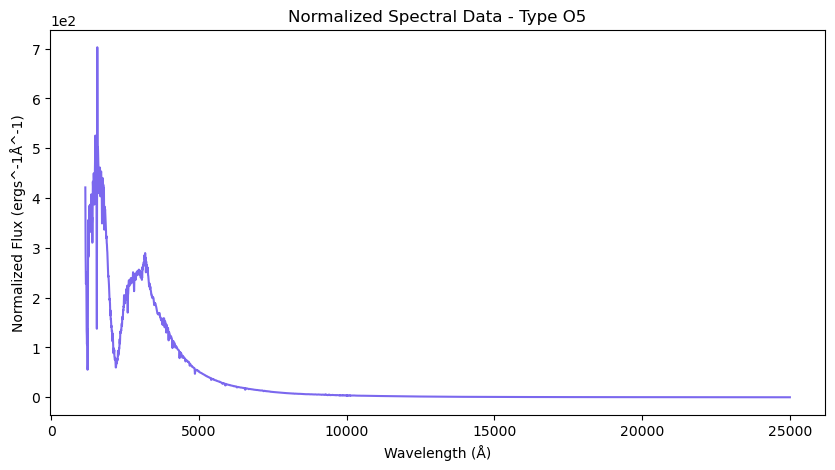

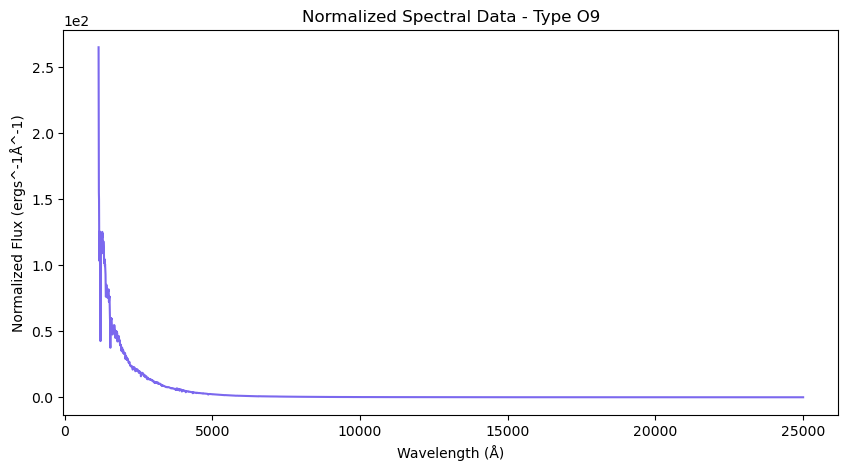

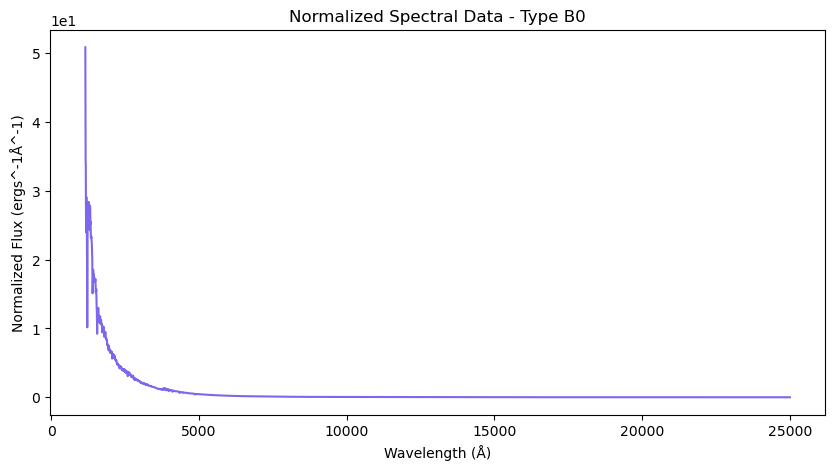

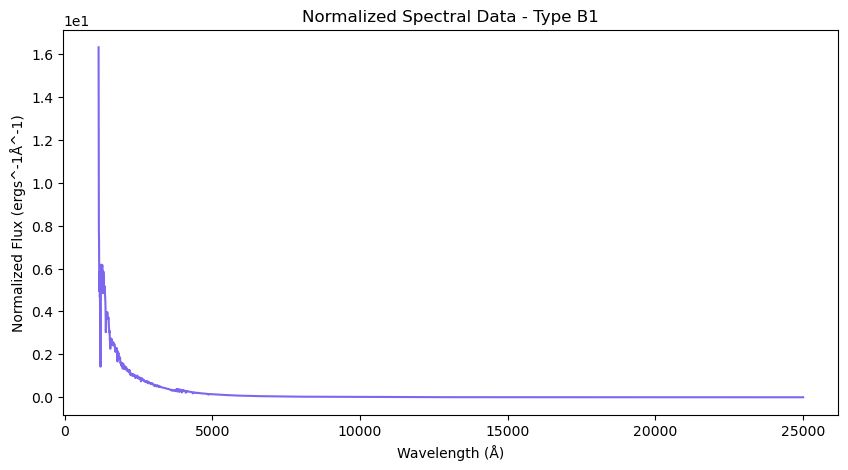

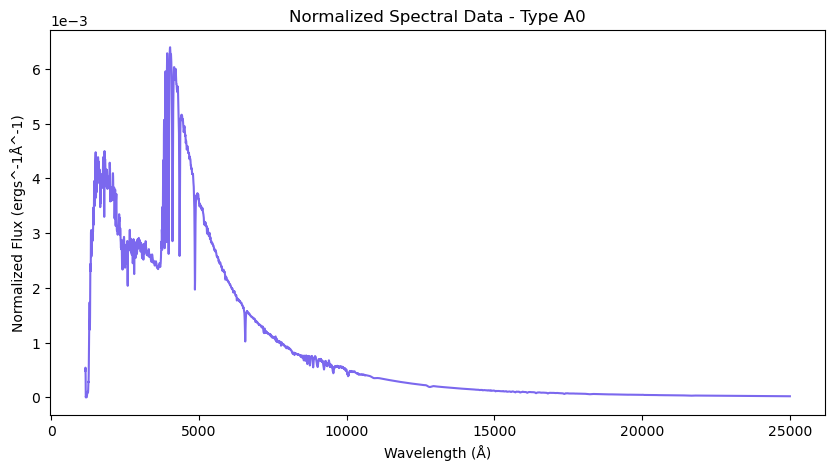

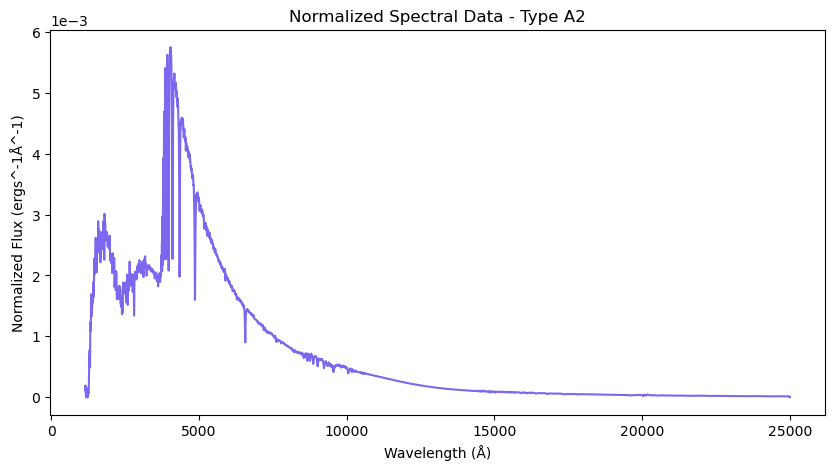

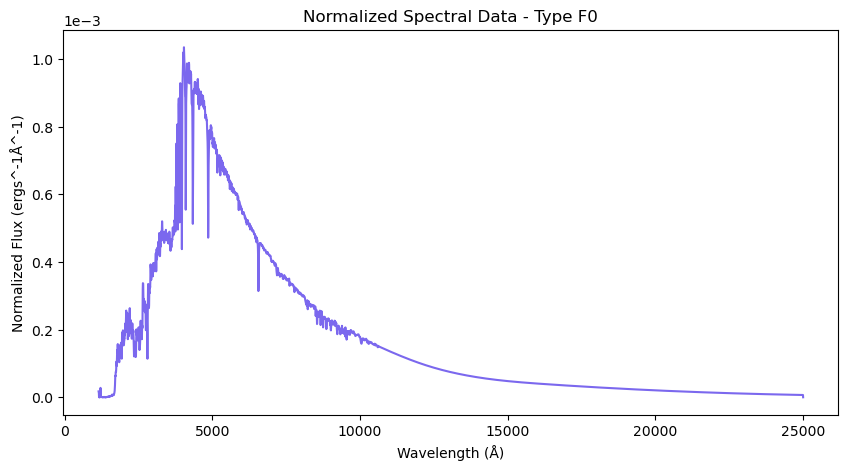

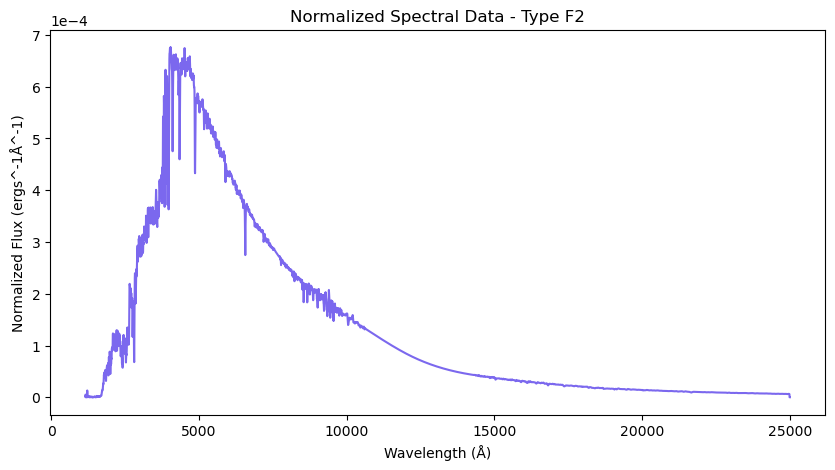

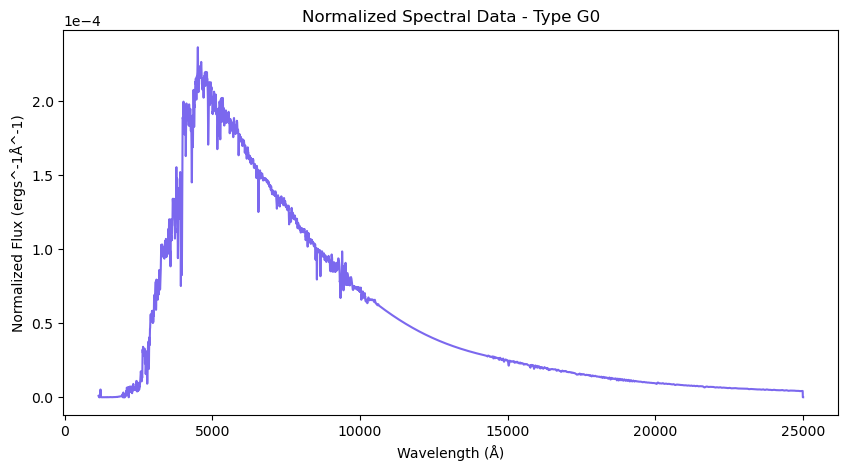

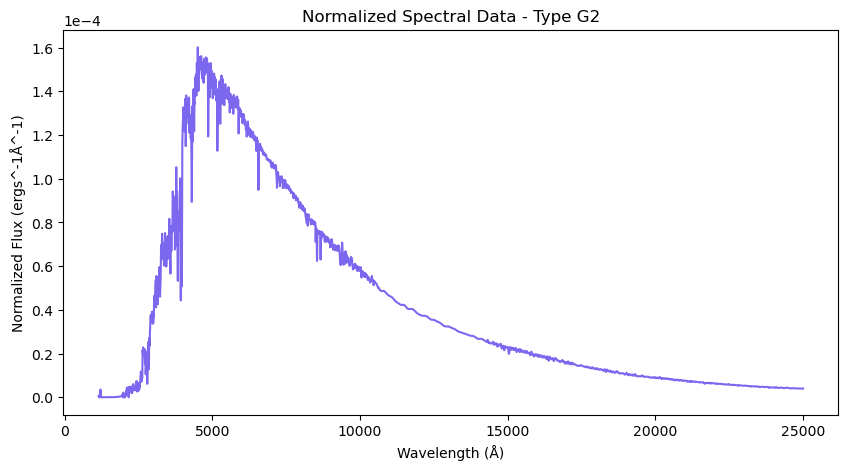

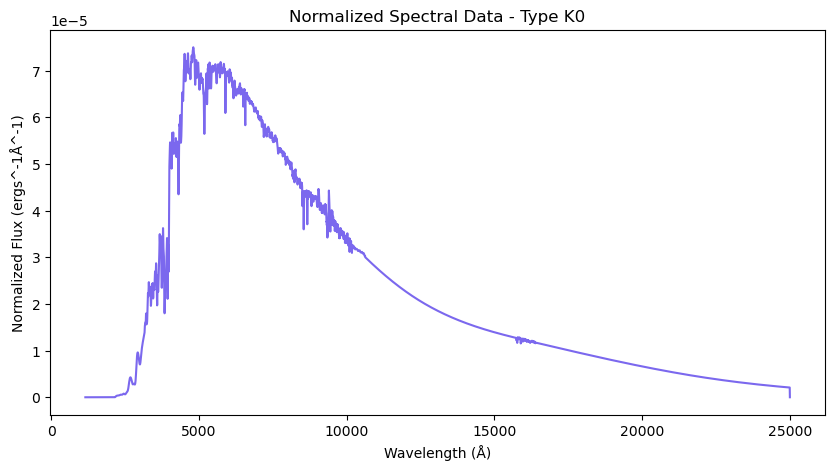

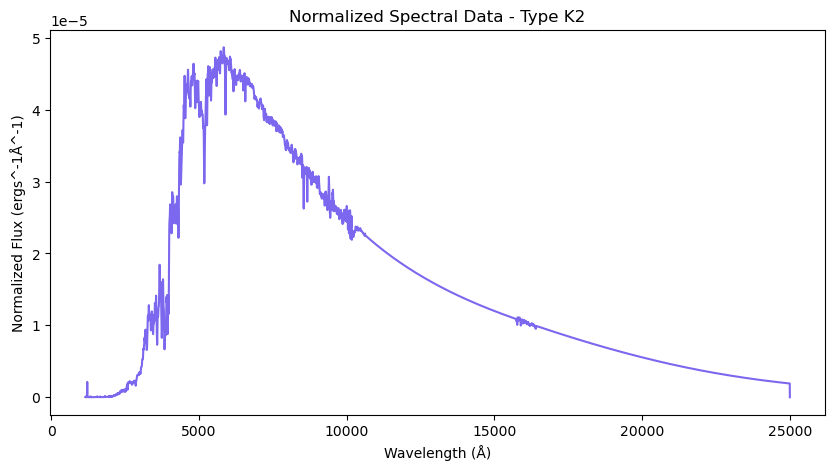

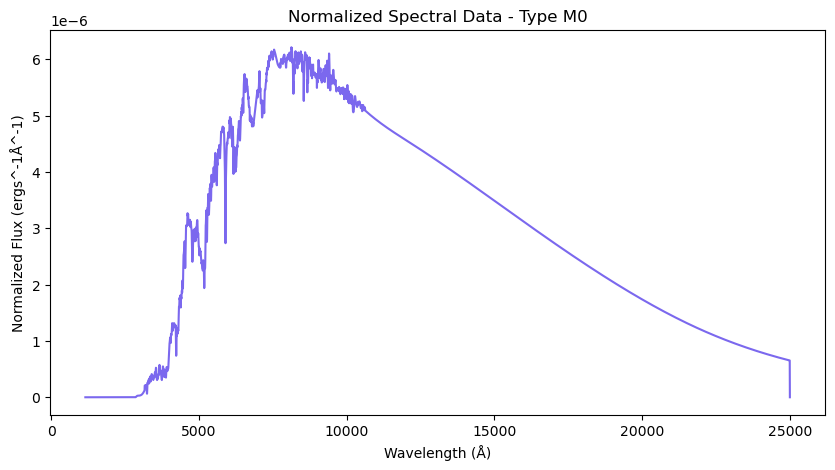

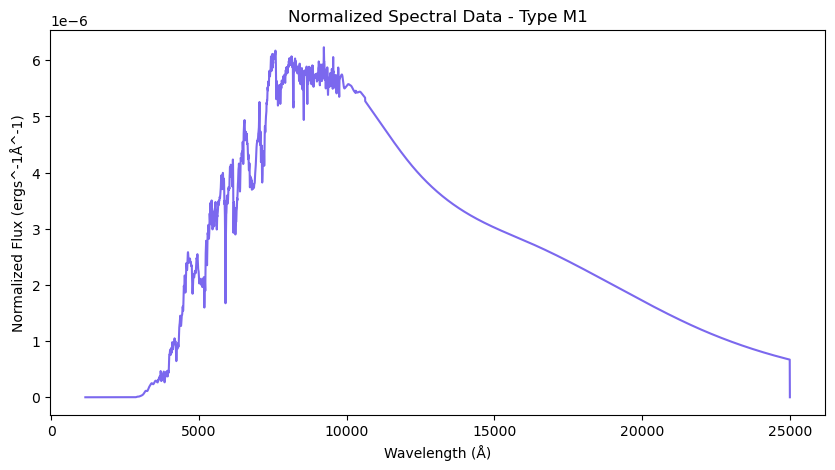

In [135]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from io import BytesIO
from ftplib import FTP

# Function to download spectrum from FTP
def download_spectrum_ftp(url):
    from urllib.parse import urlparse

    parsed_url = urlparse(url)
    ftp_host = parsed_url.hostname
    ftp_file_path = parsed_url.path

    ftp = FTP(ftp_host)
    ftp.login()

    file_data = BytesIO()
    ftp.retrbinary(f"RETR {ftp_file_path}", file_data.write)
    ftp.quit()

    file_data.seek(0)
    return file_data.read()

# Intrinsic luminosity dictionary
intrinsic_lum = {
    'O5': 846000, 'O9': 95000,
    'B0': 20000, 'B1': 4600,
    'A0': 22, 'A2': 18,
    'F0': 4.3, 'F2': 3.3,
    'G0': 1.3, 'G2': 1,
    'K0': 0.54, 'K2': 0.38,
    'M0': 0.069, 'M1': 0.064
}

# Spectra URLs dictionary with explicit spectral type mapping
spectra_urls = {
    "O5": "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/uko5v.fits",
    "O9": "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/uko9v.fits",
    "B0": "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/ukb0v.fits",
    "B1": "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/ukb1v.fits",
    "A0": "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/uka0v.fits",
    "A2": "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/uka2v.fits",
    "F0": "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/ukf0v.fits",
    "F2": "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/ukf2v.fits",
    "G0": "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/ukg0v.fits",
    "G2": "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/ukg2v.fits",
    "K0": "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/ukk0v.fits",
    "K2": "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/ukk2v.fits",
    "M0": "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/ukm0v.fits",
    "M1": "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/ukm1v.fits"
}

# Download the spectra data
spectra = {key: download_spectrum_ftp(url) for key, url in spectra_urls.items()}

# Function to open FITS data
def open_fits_from_data(data):
    with fits.open(BytesIO(data)) as hdul:
        header = hdul[0].header
        data = hdul[0].data
        return header, data

# Function to calculate the total luminosity of the spectrum
def calculate_total_luminosity(wavelength, spectrum):
    luminosity = np.trapz(spectrum, x=wavelength)
    return luminosity

# Function to normalize a stellar spectrum relative to the total luminosity
def normalize_spectrum_to_luminosity(header, data):
    crpix1 = header['CRPIX1']  # Reference pixel
    crval1 = header['CRVAL1']  # Value of the reference pixel
    cdelt1 = header['CDELT1']  # Increment per pixel

    # Calculate the wavelength range
    wavelength = crval1 + (np.arange(len(data)) - crpix1 + 1) * cdelt1

    # Calculate the total luminosity of the spectrum
    total_luminosity = calculate_total_luminosity(wavelength, data)

    # Normalize the spectrum by dividing by the total luminosity
    normalized_spectrum = data / total_luminosity

    return wavelength, normalized_spectrum, total_luminosity

# Process and plot each spectrum, multiplying by intrinsic luminosity
for spectral_type, fits_data in spectra.items():
    # Obtain the header and data from the FITS file
    header, data = open_fits_from_data(fits_data)

    # Normalize the spectrum relative to the luminosity
    wavelength, normalized_spectrum, total_luminosity = normalize_spectrum_to_luminosity(header, data)

    # Get the intrinsic luminosity
    intrinsic_luminosity = intrinsic_lum[spectral_type]

    # Multiply the normalized spectrum by the intrinsic luminosity
    intrinsic_normalized_spectrum = normalized_spectrum * intrinsic_luminosity

    # print(f'For {spectral_type} we have intrinsic normalized luminosity : {intrinsic_normalized_spectrum}')
    # Plot the spectrum
    plt.figure(figsize=(10, 5))
    plt.plot(wavelength, intrinsic_normalized_spectrum, color='mediumslateblue')
    plt.xlabel('Wavelength (Å)')
    plt.ylabel('Normalized Flux (ergs^-1Å^-1)') # ergs−1A−1
    plt.title(f'Normalized Spectral Data - Type {spectral_type}')
    plt.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
    plt.show()


# SSP, SFR, SFH

In [2]:
import numpy as np
from scipy.integrate import quad
from scipy.interpolate import interp1d

# Función para la IMF de Salpeter
def salpeter_imf(m, alpha=-2.35):
    return m ** alpha

# Función para generar una distribución de masas inicial
def generate_initial_masses(n_stars, m_min=0.08, m_max=100, alpha=-2.35):
    masses = np.random.power(-alpha, n_stars) * (m_max - m_min) + m_min
    return masses

# Generar una SFH simple
def simple_sfh(time, tau=5):
    return np.exp(-time / tau)

# Integrar la SFH para obtener el SFR en diferentes épocas
def generate_sfh(times, tau=5):
    sfr = simple_sfh(times, tau)
    return sfr

# Ejemplo de uso
n_stars = 1000
initial_masses = generate_initial_masses(n_stars)
times = np.linspace(0, 14, 100)  # 14 Gyr
sfh = generate_sfh(times)

# Interpolación para obtener la SFR en cualquier tiempo
sfh_interp = interp1d(times, sfh, kind='cubic')

# Normalización de espectros
# Esto es un ejemplo simplificado, en la práctica usarías tus datos espectrales reales
spectral_types = ['O', 'B', 'A', 'F', 'G', 'K', 'M']
luminosities = np.array([1e5, 1e3, 50, 5, 1, 0.1, 0.01])  # Ejemplo de luminosidades
normalized_spectra = {stype: lum for stype, lum in zip(spectral_types, luminosities)}

# Superposición de SSPs según la SFH
# Esto requiere combinar los espectros en función del tiempo y la SFH

# Entrenamiento del modelo ML para predecir la edad de la galaxia
from sklearn.neural_network import MLPRegressor

# Ejemplo de entrenamiento con datos sintéticos
X_train = np.random.rand(100, 500)  # Espectros sintéticos
y_train = np.random.rand(100) * 14  # Edades sintéticas (en Gyr)

model = MLPRegressor(hidden_layer_sizes=(100,), max_iter=1000)
model.fit(X_train, y_train)

# Predicción de la edad de una galaxia
X_test = np.random.rand(10, 500)  # Espectros de prueba
predicted_ages = model.predict(X_test)
print(predicted_ages)


c:\Users\ACER\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[10.83023976  6.60920934  7.09522004  5.07015564  9.87418481  8.84167401
  8.80633805  3.53594568  8.31787225  3.53562759]


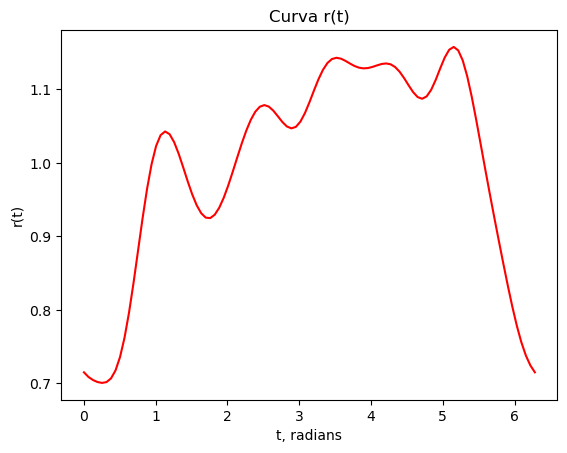

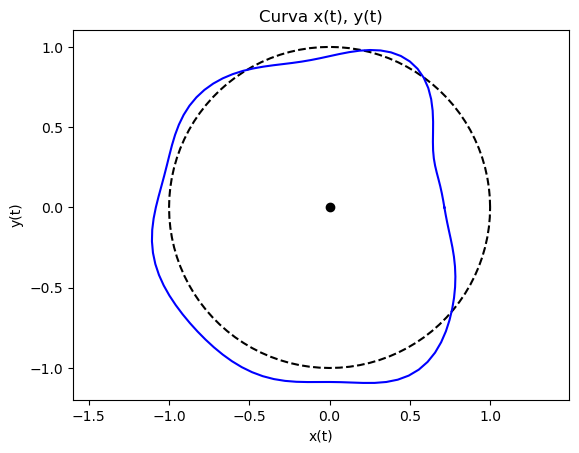

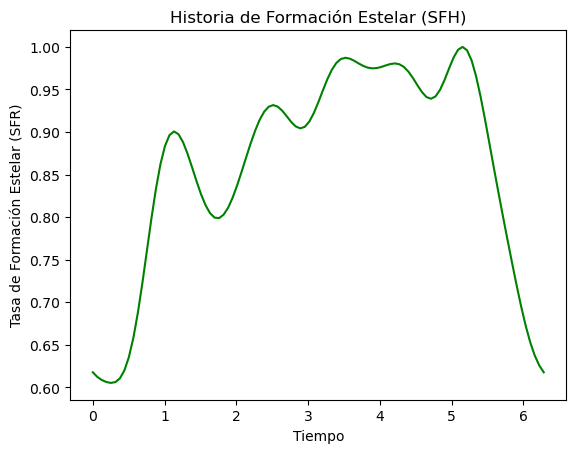

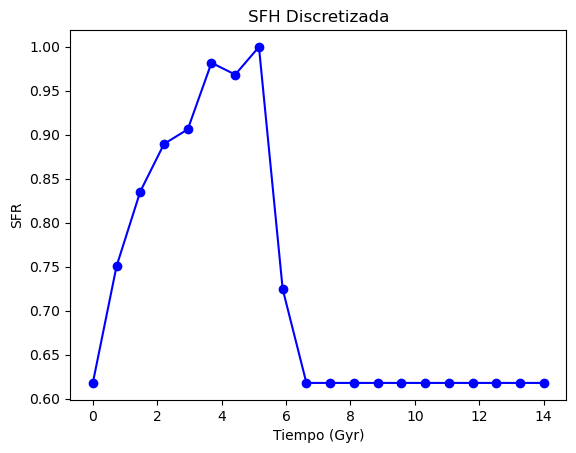

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Número de componentes en la SFH
H = 10

# Randomiza amplitud y fase
rho = np.random.rand(H) * np.logspace(-0.5, -2.5, H)
phi = np.random.rand(H) * 2 * np.pi

# Define el rango de tiempo
t = np.linspace(0, 2 * np.pi, 101)

# Inicializa r(t)
r = np.ones_like(t)

# Acumula r(t) sobre t=[0, 2*pi]
for h in range(H):
    r += rho[h] * np.sin((h + 1) * t + phi[h])

# Reconstruye x(t) y y(t)
x = r * np.cos(t)
y = r * np.sin(t)

# Plots
plt.figure()
plt.plot(t, r, 'r-')
plt.xlabel('t, radians')
plt.ylabel('r(t)')
plt.title('Curva r(t)')

plt.figure()
plt.plot(0, 0, 'ko')  # Punto de inicio
plt.plot(np.cos(t), np.sin(t), 'k--')  # Circunferencia unitaria
plt.plot(x, y, 'b-')
plt.xlabel('x(t)')
plt.ylabel('y(t)')
plt.axis('equal')
plt.title('Curva x(t), y(t)')
plt.show()

# Transformar r(t) en una función de formación estelar
def generate_sfh(t, r):
    # Normaliza r(t) para que tenga un máximo de 1
    r_normalized = r / np.max(r)
    # Interpolación de la función r(t)
    sfh_interp = np.interp(t, np.linspace(0, 2 * np.pi, len(r)), r_normalized)
    return sfh_interp

# Generar la SFH
sfh = generate_sfh(t, r)

# Plotea la SFH
plt.figure()
plt.plot(t, sfh, 'g-')
plt.xlabel('Tiempo')
plt.ylabel('Tasa de Formación Estelar (SFR)')
plt.title('Historia de Formación Estelar (SFH)')
plt.show()

# Discretizar la SFH para obtener la formación estelar en distintos intervalos de tiempo
def discretize_sfh(sfh, num_bins):
    time_bins = np.linspace(0, 14, num_bins)  # 14 Gyr
    sfh_values = np.interp(time_bins, t, sfh)
    return time_bins, sfh_values

# Parámetros de discretización
num_bins = 20
time_bins, sfh_values = discretize_sfh(sfh, num_bins)

# Plot de la SFH discretizada
plt.figure()
plt.plot(time_bins, sfh_values, 'b-o')
plt.xlabel('Tiempo (Gyr)')
plt.ylabel('SFR')
plt.title('SFH Discretizada')
plt.show()


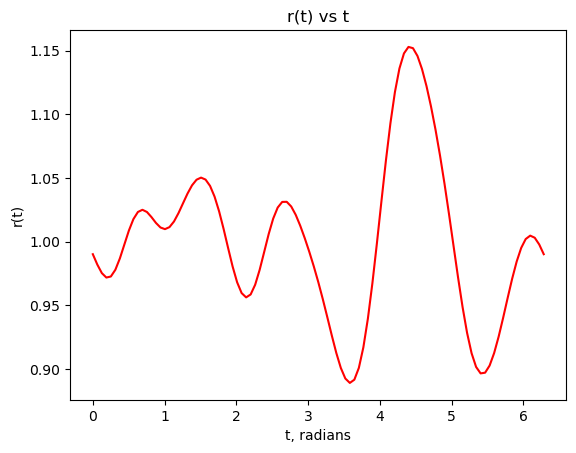

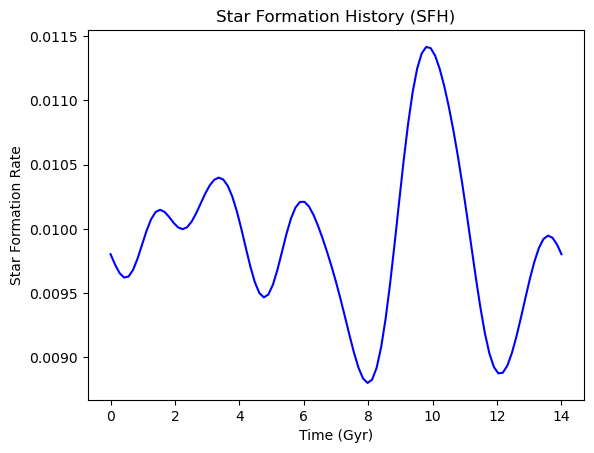

NameError: name 'get_star_spectrum' is not defined

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Randomize amplitude and phase
H = 10
rho = np.random.rand(H) * np.logspace(-0.5, -2.5, H)
phi = np.random.rand(H) * 2 * np.pi

# Accumulate r(t) over t=[0, 2*pi]
t = np.linspace(0, 2 * np.pi, 101)
r = np.ones_like(t)
for h in range(1, H + 1):
    r += rho[h - 1] * np.sin(h * t + phi[h - 1])

# Discretize r(t) for SFH
times = np.linspace(0, 14, 101)  # 14 Gyr
sfh_values = np.interp(times, np.linspace(0, 14, len(t)), r)

# Plot r(t) vs t
plt.figure()
plt.plot(t, r, 'r-')
plt.xlabel('t, radians')
plt.ylabel('r(t)')
plt.title('r(t) vs t')
plt.show()

# Use SFH values to define star formation rates
sfr = sfh_values / np.sum(sfh_values)  # Normalize to sum to 1

# Plot SFH
plt.figure()
plt.plot(times, sfr, 'b-')
plt.xlabel('Time (Gyr)')
plt.ylabel('Star Formation Rate')
plt.title('Star Formation History (SFH)')
plt.show()

# Generate SSPs based on SFH
n_populations = len(sfr)
ssps = []

for i in range(n_populations):
    n_stars = int(sfr[i] * 1000)  # Number of stars proportional to SFR
    masses = generate_initial_masses(n_stars)
    ssps.append(masses)

# Example of combining SSPs to create the galaxy spectrum
combined_spectrum = np.zeros(7501)  # Example: 7501 wavelength points

for i, masses in enumerate(ssps):
    for mass in masses:
        # Assume `get_star_spectrum` function that returns the spectrum of a star given its mass
        star_spectrum = get_star_spectrum(mass)
        combined_spectrum += star_spectrum

# Normalize combined spectrum
combined_spectrum /= np.sum(combined_spectrum)

# Plot the combined spectrum
plt.figure()
wavelengths = np.linspace(2500, 10000, 7501)
plt.plot(wavelengths, combined_spectrum)
plt.xlabel('Wavelength (Å)')
plt.ylabel('Flux')
plt.title('Combined Galaxy Spectrum')
plt.show()

# Define `get_star_spectrum` function (this is just a placeholder, you need actual data)
def get_star_spectrum(mass):
    # Placeholder: return a spectrum based on the mass
    return np.exp(-0.1 * np.linspace(0, 7500, 7501)) * mass


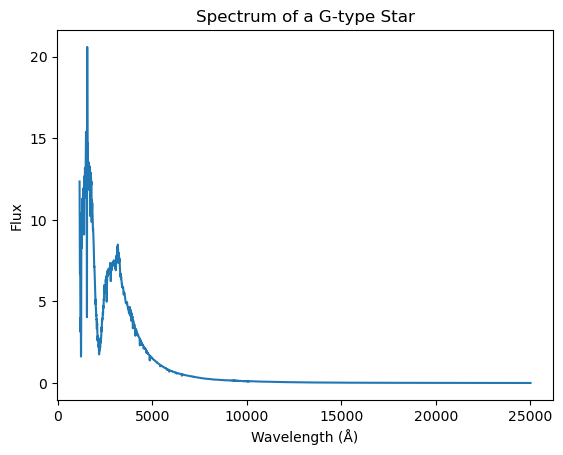

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from io import BytesIO
from ftplib import FTP

# Función para descargar espectros desde FTP (ya proporcionada)
def download_spectrum_ftp(ftp_url):
    ftp_host = "ftp.eso.org"
    ftp_path = ftp_url.replace("ftp://ftp.eso.org/", "")
    
    with FTP(ftp_host) as ftp:
        ftp.login()
        with BytesIO() as bio:
            ftp.retrbinary(f"RETR {ftp_path}", bio.write)
            bio.seek(0)
            return bio.getvalue()

# URLs de espectros organizados por tipo espectral (ya proporcionado)
spectra_urls = {
    "O": [
        "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/uko5v.fits",
        "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/uko9v.fits"
    ],
    "B": [
        "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/ukb0v.fits",
        "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/ukb1v.fits"
    ],
    "A": [
        "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/uka0v.fits",
        "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/uka2v.fits"
    ],
    "F": [
        "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/ukf0v.fits",
        "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/ukf2v.fits"
    ],
    "G": [
        "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/ukg0v.fits",
        "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/ukg2v.fits"
    ],
    "K": [
        "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/ukk0v.fits",
        "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/ukk2v.fits"
    ],
    "M": [
        "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/ukm0v.fits",
        "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/ukm1v.fits"
    ]
}

# Descarga de los espectros y almacenamiento en un diccionario
spectra = {}
for key, urls in spectra_urls.items():
    spectra[key] = [download_spectrum_ftp(url) for url in urls]

# Función para leer el espectro desde un archivo FITS en memoria
def read_spectrum_from_fits(data):
    with fits.open(BytesIO(data)) as hdul:
        spectrum_data = hdul[0].data
        header = hdul[0].header
        wavelengths = np.arange(header['CRVAL1'], header['CRVAL1'] + header['CDELT1'] * len(spectrum_data), header['CDELT1'])
        return wavelengths[:len(spectrum_data)], spectrum_data

# Ejemplo de función para obtener el espectro de una estrella dado su tipo espectral
def get_star_spectrum(spectral_type):
    # Selecciona un espectro al azar de los disponibles para el tipo espectral dado
    if spectral_type in spectra:
        data = spectra[spectral_type][0]  # Puedes ajustar la selección aleatoria o específica
        wavelengths, spectrum = read_spectrum_from_fits(data)
        return wavelengths, spectrum
    else:
        raise ValueError(f"Spectral type {spectral_type} not available in spectra.")

# Ejemplo de uso de get_star_spectrum
wavelengths, spectrum = get_star_spectrum("O")

# Plot del espectro
plt.plot(wavelengths, spectrum)
plt.xlabel("Wavelength (Å)")
plt.ylabel("Flux")
plt.title("Spectrum of a G-type Star")
plt.show()


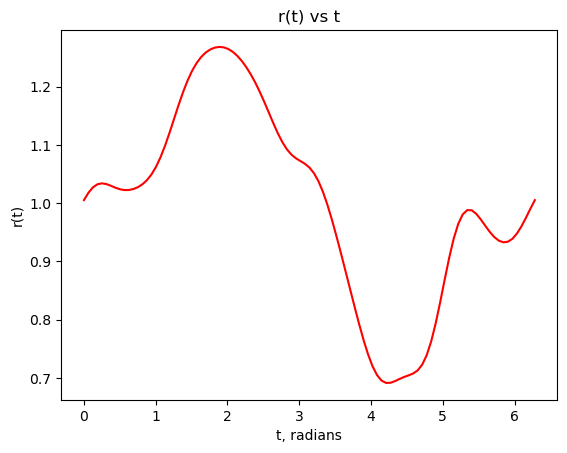

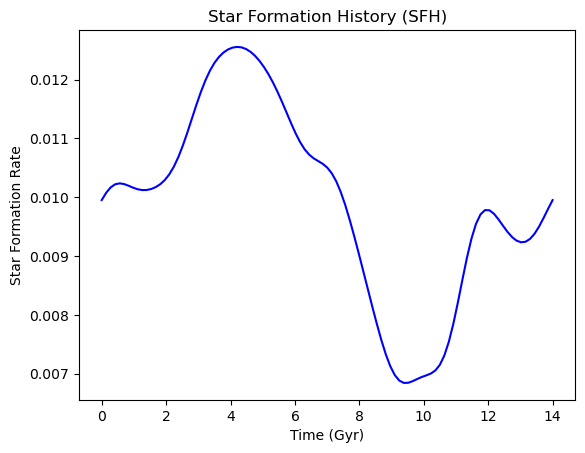

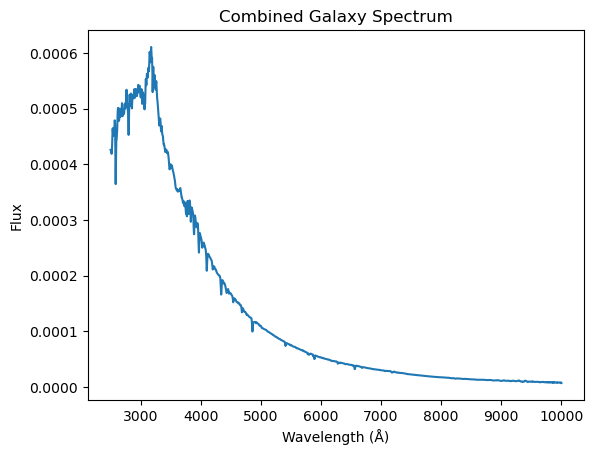

In [13]:


# Masas de mentira AJUSTAR ESTO A MASAS REALES
def mass_to_spectral_type(mass):
    if mass > 16:
        return "O"
    elif mass > 2.1:
        return "B"
    elif mass > 1.4:
        return "A"
    elif mass > 1.04:
        return "F"
    elif mass > 0.8:
        return "G"
    elif mass > 0.45:
        return "K"
    else:
        return "M"

# IMF de mentira
def generate_initial_masses(n_stars):
    alpha = 2.35
    m_min = 0.08
    m_max = 100
    masses = np.random.power(alpha, n_stars)
    masses = m_min + (m_max - m_min) * masses
    return masses

# OCUPA LOS ESPECTROS REALES
def get_star_spectrum(spectral_type):
    if spectral_type in spectra:
        data = spectra[spectral_type][0]
        wavelengths, spectrum = read_spectrum_from_fits(data)
        return wavelengths, spectrum
    else:
        raise ValueError(f"Spectral type {spectral_type} not available in spectra.")

# SFH con random, del codigo que mando DNILO
H = 10
rho = np.random.rand(H) * np.logspace(-0.5, -2.5, H)
phi = np.random.rand(H) * 2 * np.pi

t = np.linspace(0, 2 * np.pi, 101)
r = np.ones_like(t)
for h in range(1, H + 1):
    r += rho[h - 1] * np.sin(h * t + phi[h - 1])

# DISCRTEIZAR A 14 GYR, cambiar esto, como elegimos esta edad
times = np.linspace(0, 14, 101)  # 14 Gyr
sfh_values = np.interp(times, np.linspace(0, 14, len(t)), r)

# SFR =  normalizacion de sfh???
sfr = sfh_values / np.sum(sfh_values)  # Normalize to sum to 1

# Plot SFH curve
plt.figure()
plt.plot(t, r, 'r-')
plt.xlabel('t, radians')
plt.ylabel('r(t)')
plt.title('r(t) vs t')
plt.show()

plt.figure()
plt.plot(times, sfr, 'b-')
plt.xlabel('Time (Gyr)')
plt.ylabel('Star Formation Rate')
plt.title('Star Formation History (SFH)')
plt.show()

# numero de estreellas que se haran en la formacion de la galaxia
total_stars = 10000

# SSP en base a sfr
n_populations = len(sfr)
ssps = []

for i in range(n_populations):
    n_stars = int(sfr[i] * total_stars)  # Number of stars proportional to SFR
    masses = generate_initial_masses(n_stars)
    ssps.append(masses)

# Combine SSPs to create the galaxy spectrum
combined_spectrum = np.zeros(7501)  # Example: 7501 wavelength points
common_wavelengths = np.linspace(2500, 10000, 7501)

for i, masses in enumerate(ssps):
    for mass in masses:
        spectral_type = mass_to_spectral_type(mass)
        wavelengths, star_spectrum = get_star_spectrum(spectral_type)
        
        # Interpolate star_spectrum to the common wavelengths
        interpolated_spectrum = np.interp(common_wavelengths, wavelengths, star_spectrum)
        combined_spectrum += interpolated_spectrum

# Normalize combined spectrum
combined_spectrum /= np.sum(combined_spectrum)

# Plot combined galaxy spectrum
plt.figure()
plt.plot(common_wavelengths, combined_spectrum)
plt.xlabel('Wavelength (Å)')
plt.ylabel('Flux')
plt.title('Combined Galaxy Spectrum')
plt.show()
